In [17]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Reading data

In [18]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
268,269,1,1,"Graham, Mrs. William Thompson (Edith Junkins)",female,58.0,0,1,PC 17582,153.4625,C125,S
838,839,1,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S
420,421,0,3,"Gheorgheff, Mr. Stanio",male,NaN,0,0,349254,7.8958,NaN,C
267,268,1,3,"Persson, Mr. Ernst Ulrik",male,25.0,1,0,347083,7.7750,NaN,S
806,807,0,1,"Andrews, Mr. Thomas Jr",male,39.0,0,0,112050,0.0000,A36,S
767,768,0,3,"Mangan, Miss. Mary",female,30.5,0,0,364850,7.7500,NaN,Q
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
116,117,0,3,"Connors, Mr. Patrick",male,70.5,0,0,370369,7.7500,NaN,Q
225,226,0,3,"Berglund, Mr. Karl Ivar Sven",male,22.0,0,0,PP 4348,9.3500,NaN,S
475,476,0,1,"Clifford, Mr. George Quincy",male,NaN,0,0,110465,52.0000,A14,S


In [19]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.sample(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
198,1090,2,"Baimbrigge, Mr. Charles Robert",male,23.0,0,0,C.A. 31030,10.5000,NaN,S
283,1175,3,"Touma, Miss. Maria Youssef",female,9.0,1,1,2650,15.2458,NaN,C
210,1102,3,"Andersen, Mr. Albert Karvin",male,32.0,0,0,C 4001,22.5250,NaN,S
83,975,3,"Demetri, Mr. Marinko",male,NaN,0,0,349238,7.8958,NaN,S
186,1078,2,"Phillips, Miss. Alice Frances Louisa",female,21.0,0,1,S.O./P.P. 2,21.0000,NaN,S
290,1182,1,"Rheims, Mr. George Alexander Lucien",male,NaN,0,0,PC 17607,39.6000,NaN,S
10,902,3,"Ilieff, Mr. Ylio",male,NaN,0,0,349220,7.8958,NaN,S
126,1018,3,"Brobeck, Mr. Karl Rudolf",male,22.0,0,0,350045,7.7958,NaN,S
11,903,1,"Jones, Mr. Charles Cresson",male,46.0,0,0,694,26.0000,NaN,S
394,1286,3,"Kink-Heilmann, Mr. Anton",male,29.0,3,1,315153,22.0250,NaN,S


## First data preprocessing

In [20]:
train_data.Cabin = train_data.Cabin.apply(lambda s: str(s)[0] if type(s) != float  else 'Unknown')
test_data.Cabin = test_data.Cabin.apply(lambda s: str(s)[0] if type(s) != float  else 'Unknown')

train_data.Cabin.head()

0    Unknown
1          C
2    Unknown
3          C
4    Unknown
Name: Cabin, dtype: object

## Feature engineering with dummies

In [21]:
def dummy(data, obj_features):
    dummy_data = pd.get_dummies(data[obj_features])
    dummy_data['PassengerId'] = data['PassengerId']
    df = dummy_data.merge(data[["PassengerId", "Fare", "Age"]], on = 'PassengerId',  how = 'inner')
    return df

y = train_data["Survived"] # уберем Survived, т.к. в тестовом df его нет
object_features = ["Pclass", "Sex", "SibSp", "Parch", "Embarked", "Cabin"]

X_train = dummy(train_data, object_features)
X_test = dummy(test_data, object_features)

In [22]:
X_train = X_train.merge(train_data[["PassengerId", "Survived"]], on = "PassengerId", how = "inner")
X_train.sample(5)

,Pclass,SibSp,Parch,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,...,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_Unknown,PassengerId,Fare,Age,Survived
506,2,0,2,1,0,0,0,1,0,0,...,0,0,0,0,0,1,507,26.0000,33.0,1
88,1,3,2,1,0,0,0,1,0,0,...,0,0,0,0,0,0,89,263.0000,23.0,1
852,3,1,1,1,0,1,0,0,0,0,...,0,0,0,0,0,1,853,15.2458,9.0,0
126,3,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,127,7.7500,NaN,0
854,2,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,855,26.0000,44.0,0


In [23]:
X_train.info()
print('\n::::::::::::::::::::::::::::::::::::::::::::\n')
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         891 non-null    int64  
 1   SibSp          891 non-null    int64  
 2   Parch          891 non-null    int64  
 3   Sex_female     891 non-null    uint8  
 4   Sex_male       891 non-null    uint8  
 5   Embarked_C     891 non-null    uint8  
 6   Embarked_Q     891 non-null    uint8  
 7   Embarked_S     891 non-null    uint8  
 8   Cabin_A        891 non-null    uint8  
 9   Cabin_B        891 non-null    uint8  
 10  Cabin_C        891 non-null    uint8  
 11  Cabin_D        891 non-null    uint8  
 12  Cabin_E        891 non-null    uint8  
 13  Cabin_F        891 non-null    uint8  
 14  Cabin_G        891 non-null    uint8  
 15  Cabin_T        891 non-null    uint8  
 16  Cabin_Unknown  891 non-null    uint8  
 17  PassengerId    891 non-null    int64  
 18  Fare      

## Visualization

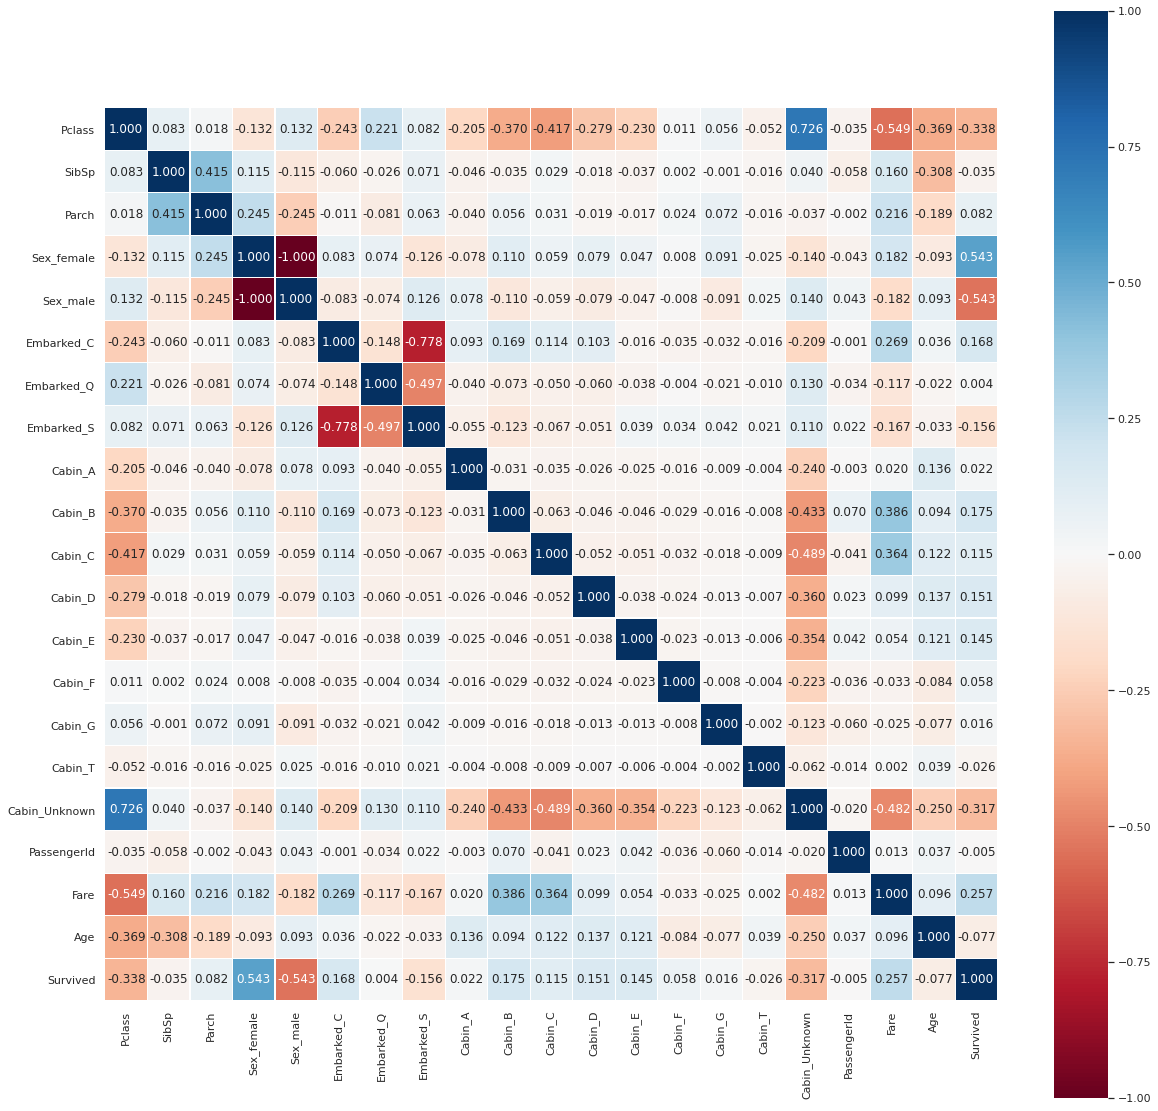

In [24]:
sns.set(font_scale=1)
plt.subplots(figsize=(20, 20))
sns.heatmap(X_train.corr(), square=True,
              annot=True, fmt=".3f", linewidths=0.1, cmap="RdBu")

## Second data preprocessing

In [25]:
q_fare = X_train.Fare.describe().loc[["25%", "75%"]]
q_age = X_train.Age.describe().loc[["25%", "75%"]]

In [26]:
X_test.Age.fillna(value = X_test.Age.mean(), inplace = True) # заполним пропуски
X_test.Fare.fillna(value = X_test.Age.std(), inplace = True)

# повысим корреляцию признаков и целевой переменной, введя новые классы, зависящие от квантилей

X_train.Fare = X_train.Fare.apply(lambda fare: 0 if fare < q_fare["25%"] else
                                  (1 if fare >= q_fare["25%"] and fare < q_fare["75%"] else 2))

X_train.Age = X_train.Age.apply(lambda age: 0 if age < q_age["25%"] else
                                (1 if age >= q_age["25%"] and age < q_age["75%"] else 2))

# корреляция действительно увеличилась

print(f"corrcoef(Fare, y) = {np.corrcoef(X_train.Fare, y)[0][1]}")
print(f"corrcoef(Age, y) =  {np.corrcoef(X_train.Age, y)[0][1]}")

X_test.Fare = X_test.Fare.apply(lambda fare: 0 if fare < q_fare["25%"] else
                                (1 if fare >= q_fare["25%"] and fare < q_fare["75%"] else 2))

X_test.Age = X_test.Age.apply(lambda age: 0 if age < q_age["25%"] else
                              (1 if age >= q_age["25%"] and age < q_age["75%"] else 2))

X_train.drop(["Cabin_T"], axis = "columns", inplace = True)

corrcoef(Fare, y) = 0.2806550638580532
corrcoef(Age, y) =  -0.09315520072264195


In [27]:
X_train.head(5)

,Pclass,SibSp,Parch,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_Unknown,PassengerId,Fare,Age,Survived
0,3,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0
1,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,2,2,2,1
2,3,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,3,1,1,1
3,1,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,4,2,1,1
4,3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,5,1,1,0


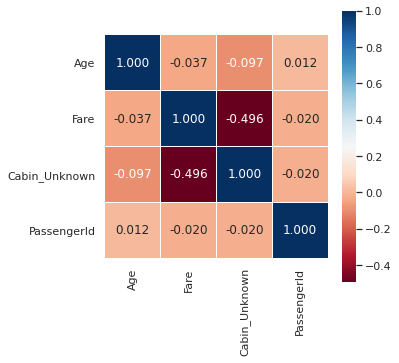

In [28]:
sns.set(font_scale=1)
plt.subplots(figsize=(5, 5))
sns.heatmap(X_train[["Age", "Fare", "Cabin_Unknown", "PassengerId"]].corr(), square=True, 
            annot=True, fmt=".3f", linewidths=0.1, cmap="RdBu")

In [29]:
pass_id = X_test["PassengerId"]

X_train.drop(["PassengerId"], axis = "columns", inplace = True)
X_test.drop(["PassengerId"], axis = "columns", inplace = True)

## Machine learning

In [30]:
forest = RandomForestClassifier(n_estimators = 2500, max_depth = 9, random_state = 77) # используем случайный лес

In [31]:
Y_train = X_train.Survived
X_train.drop(["Survived"], axis = "columns", inplace = True)
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 77)

In [32]:
forest.fit(x_train, y_train)
predictions = forest.predict(x_test)

print(f"f1-score = {np.round(f1_score(predictions, y_test), 4)}")

f1-score = 0.8246


In [33]:
forest.fit(X_train, y)
predictions = forest.predict(X_test)

In [34]:
forest.fit(X_train, y)
predictions = forest.predict(X_test)

output = pd.DataFrame({'PassengerId': pass_id, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)